# 1 Jahr Frauenparlament: Analyse der Motionen

In [3]:
# import libraries
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt

#### Daten-Import

In [4]:
redezeiten = pd.read_csv("input/redezeiten.csv")

In [5]:
full_data = pd.read_pickle('internal/data.pkl')

#### Kontrolle der Daten

In [6]:
# Andere "Gruppen"
full_data[(pd.isnull(full_data.GenderAsString)) | (pd.isnull(full_data.PartyAbbreviation)) | (full_data.PartyAbbreviation == "-")].SubmittedBy.unique()

array(['Lumengo Ricardo', 'Clottu Raymond'], dtype=object)

In [7]:
## prüfen ob alle Personen mit Geschlechts-Bezeichnung versehen sind
full_data[(pd.isnull(full_data.GenderAsString))].SubmittedBy.unique()

array([], dtype=object)

In [8]:
# Anzahl Motionen aus dem NR in der 51. Legislatur
len(full_data[full_data.SubmissionLegislativePeriod == 51].ID_x.unique())

431

In [9]:
# Anzahl Motionen aus dem NR in der 50. Legislatur
len(full_data[full_data.SubmissionLegislativePeriod == 50].ID_x.unique())

1306

#### Tabellen für Auswertungen vorbereiten

In [10]:
# Liste mit allen Themen-Schlagworten
tag_list = []
for i, row in full_data.iterrows():
    if(row['TagNames']):
        tags = row['TagNames'].split('|')
        for tag in tags:
            tag_list.append([row['ID_x'], tag, row['Title'],
                             row['SubmissionLegislativePeriod'], row['FirstName'],
                             row['LastName'], row['GenderAsString'], row['NewMember'],
                             row['CantonAbbreviation'], row['CouncilAbbreviation'],
                             row['ParlGroupAbbreviation'], row['PartyAbbreviation']])

tag_list = pd.DataFrame(tag_list, columns = ['ID', 'tag', 'Title', 'SubmissionLegislativePeriod',
                                             'FirstName', 'LastName', 'GenderAsString', 'NewMember',
                                             'CantonAbbreviation','CouncilAbbreviation',
                                             'ParlGroupAbbreviation', 'PartyAbbreviation'])


In [11]:
# ...gebündelt nach Legislaturperiode
tag_grouped = tag_list[['tag', 'SubmissionLegislativePeriod', 'ID']].groupby(['SubmissionLegislativePeriod', 'tag']).count().reset_index()

In [12]:
# ...gebündelt nach Partei (und Legislaturperiode)
tag_parties = tag_list[~(tag_list.PartyAbbreviation == "-")][['tag', 'SubmissionLegislativePeriod', 'PartyAbbreviation', 'ID']].groupby(['SubmissionLegislativePeriod', 'PartyAbbreviation', 'tag']).count().reset_index()

In [13]:
# ...gebündelt nach Geschlecht (und Legislaturperiode)
tag_gender = tag_list[~pd.isnull(tag_list.GenderAsString)][['tag', 'GenderAsString', 'SubmissionLegislativePeriod', 'ID']].groupby(['SubmissionLegislativePeriod', 'GenderAsString', 'tag']).count().reset_index()

In [14]:
# ...gebündelt nach Fraktion (und Legislaturperiode)
tag_parlgroup = tag_list[~(pd.isnull(tag_list.ParlGroupAbbreviation))][['tag', 'SubmissionLegislativePeriod', 'ParlGroupAbbreviation', 'ID']].groupby(['SubmissionLegislativePeriod', 'ParlGroupAbbreviation', 'tag']).count().reset_index()

In [23]:
# ...gebündelt nach Geschlecht und Fraktion (und Legislaturperiode)
tag_parlgroup_gender = tag_list[~(pd.isnull(tag_list.ParlGroupAbbreviation))][['tag', 'SubmissionLegislativePeriod', 'ParlGroupAbbreviation', 'GenderAsString', 'ID']].groupby(['SubmissionLegislativePeriod', 'ParlGroupAbbreviation', 'GenderAsString', 'tag']).count().reset_index()

In [15]:
# ...gebündelt nach Neugewählten bzw. Amtsinhabern (und Legislaturperiode)
tag_newmembers = tag_list[~(pd.isnull(tag_list.ParlGroupAbbreviation)) & (tag_list.SubmissionLegislativePeriod == 51) & (tag_list.GenderAsString == 'f')][['tag', 'SubmissionLegislativePeriod', 'NewMember', 'ID']].groupby(['SubmissionLegislativePeriod', 'NewMember', 'tag']).count().reset_index()

In [18]:
## Prozent der Motionenen denen eine Person zugewiesen ist
100 / len(tag_list[['ID', 'GenderAsString']].drop_duplicates()) * len(tag_list[~pd.isnull(tag_list.GenderAsString)][['ID', 'GenderAsString']].drop_duplicates())

100.0

In [19]:
## Prozent der Motionenen denen eine Partei zugewiesen ist
100 / len(tag_list[['ID', 'PartyAbbreviation']].drop_duplicates()) * len(tag_list[(~pd.isnull(tag_list.PartyAbbreviation)) & ~(tag_list.PartyAbbreviation == "-")][['ID', 'PartyAbbreviation']].drop_duplicates())

99.81352771656213

## Unterschiede 50. + 51. Legislatur

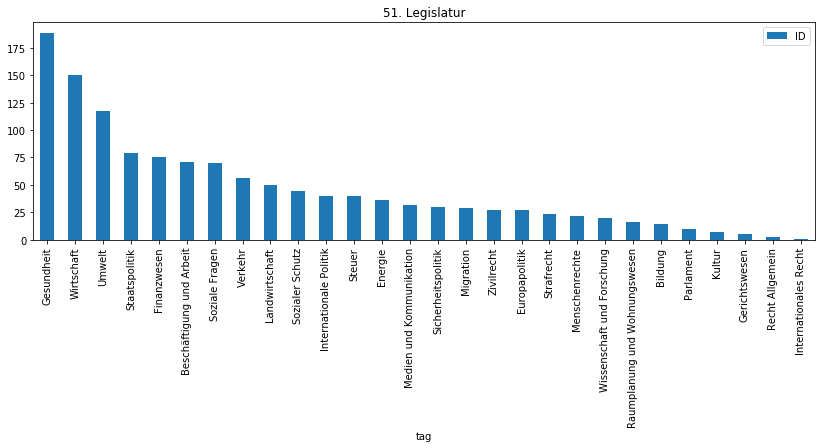

In [20]:
# Verteilung der Them-Schlagworte in der 51. Legislatur
tag_grouped[tag_grouped.SubmissionLegislativePeriod == 51].sort_values(by="ID", ascending=False).plot.bar(x="tag", y="ID", title="51. Legislatur", figsize=(14,4))

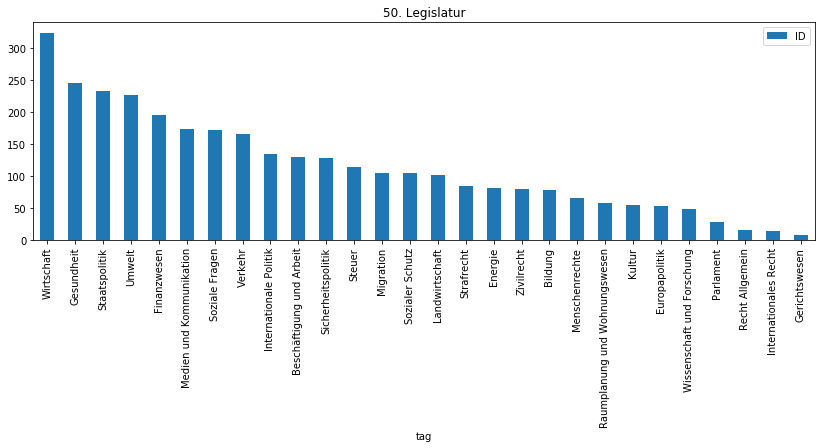

In [21]:
# Verteilung der Them-Schlagworte in der 50. Legislatur
tag_grouped[tag_grouped.SubmissionLegislativePeriod == 50].sort_values(by="ID", ascending=False).plot.bar(x="tag", y="ID", title="50. Legislatur", figsize=(14,4))

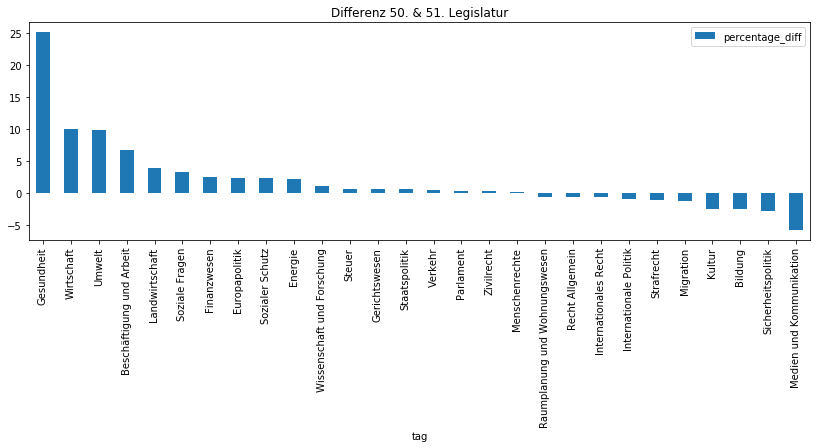

In [31]:
# Unterschiede 50 / 51 Legislatur
tag_diff = tag_grouped[(tag_grouped.SubmissionLegislativePeriod == 51)][['tag', 'ID']].merge(tag_grouped[(tag_grouped.SubmissionLegislativePeriod == 50)][['tag', 'ID']], on='tag', how='outer')
tag_diff['percentage_51'] = 100 / len(full_data[full_data.SubmissionLegislativePeriod == 51]) * tag_diff.ID_x
tag_diff['percentage_50'] = 100 / len(full_data[full_data.SubmissionLegislativePeriod == 50]) * tag_diff.ID_y
tag_diff['percentage_diff'] = tag_diff.percentage_51 - tag_diff.percentage_50
tag_diff.sort_values(by="percentage_diff", ascending=False).plot.bar(x='tag', y='percentage_diff', title="Differenz 50. & 51. Legislatur", figsize=(14,4))

In [32]:
# Liste der Unterschiede zwischen 50. und 51. Legislatur
tag_diff.sort_values(by="percentage_diff", ascending=False)

,tag,ID_x,ID_y,percentage_51,percentage_50,percentage_diff
6,Gesundheit,189,245,43.851508,18.759571,25.091937
25,Wirtschaft,150,324,34.802784,24.808576,9.994208
23,Umwelt,117,226,27.146172,17.304747,9.841424
0,Beschäftigung und Arbeit,71,129,16.473318,9.877489,6.595829
10,Landwirtschaft,50,101,11.600928,7.733538,3.867391
18,Soziale Fragen,70,171,16.241299,13.093415,3.147884
4,Finanzwesen,75,195,17.401392,14.931087,2.470305
3,Europapolitik,27,52,6.264501,3.981623,2.282878
19,Sozialer Schutz,44,104,10.208817,7.963247,2.245570
2,Energie,36,81,8.352668,6.202144,2.150524


## Themen nach Fraktion

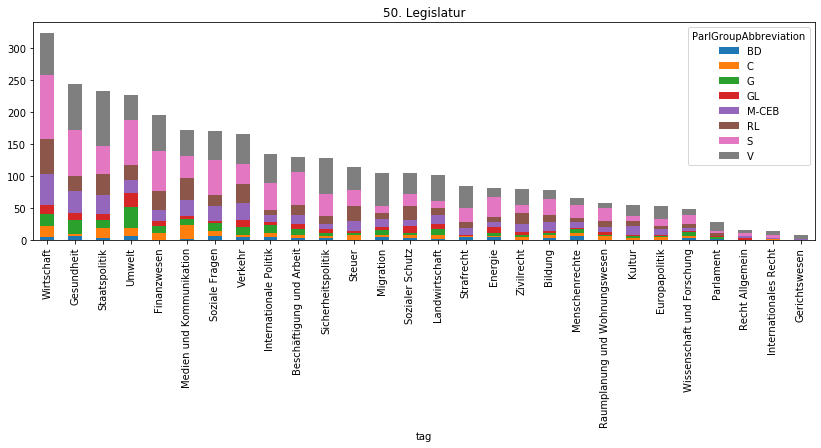

In [22]:
# in der 51. Legislatur
temp = tag_parlgroup[tag_parlgroup.SubmissionLegislativePeriod == 50].pivot(index='tag', columns='ParlGroupAbbreviation', values='ID')
temp['sum'] = temp.sum(axis=1)
temp.sort_values(by='sum', ascending=False).drop(columns=['sum']).plot.bar(stacked=True, title="50. Legislatur", figsize=(14,4))

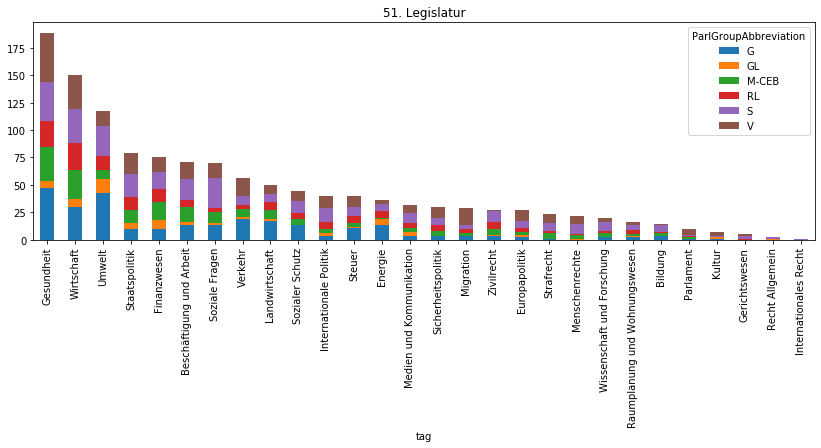

In [23]:
# in der 50. Legislatur
temp = tag_parlgroup[tag_parlgroup.SubmissionLegislativePeriod == 51].pivot(index='tag', columns='ParlGroupAbbreviation', values='ID')
temp['sum'] = temp.sum(axis=1)
temp.sort_values(by='sum', ascending=False).drop(columns=['sum']).plot.bar(stacked=True, title="51. Legislatur", figsize=(14,4))

## Unterschiede Männer & Frauen

In [33]:
# Anteil der Vorstösse seit der 46. Legislatur
for period in tag_list.SubmissionLegislativePeriod.unique():
    for gender in ['m','f']:
        gender_bezeichung = 'Frauen' if gender == 'f' else 'Männern'
        anz_vorstoesse = len(tag_list[(tag_list.SubmissionLegislativePeriod == period) & (tag_list.GenderAsString == gender)].ID.unique())
        alle_vorstoesse = len(tag_list[(tag_list.SubmissionLegislativePeriod == period)].ID.unique())
        pct_vorstoesse = 100 / alle_vorstoesse * anz_vorstoesse
        print(f"Anzahl Vorstösse von {gender_bezeichung} in der {period}. Legislatur: {anz_vorstoesse} ({pct_vorstoesse:.1f}%)")   

Anzahl Vorstösse von Männern in der 46. Legislatur: 379 (69.3%)
Anzahl Vorstösse von Frauen in der 46. Legislatur: 168 (30.7%)
Anzahl Vorstösse von Männern in der 47. Legislatur: 650 (69.0%)
Anzahl Vorstösse von Frauen in der 47. Legislatur: 292 (31.0%)
Anzahl Vorstösse von Männern in der 48. Legislatur: 954 (64.5%)
Anzahl Vorstösse von Frauen in der 48. Legislatur: 524 (35.5%)
Anzahl Vorstösse von Männern in der 49. Legislatur: 829 (69.4%)
Anzahl Vorstösse von Frauen in der 49. Legislatur: 366 (30.6%)
Anzahl Vorstösse von Männern in der 50. Legislatur: 901 (69.0%)
Anzahl Vorstösse von Frauen in der 50. Legislatur: 405 (31.0%)
Anzahl Vorstösse von Männern in der 51. Legislatur: 243 (56.4%)
Anzahl Vorstösse von Frauen in der 51. Legislatur: 188 (43.6%)


#### 51. Legislatur

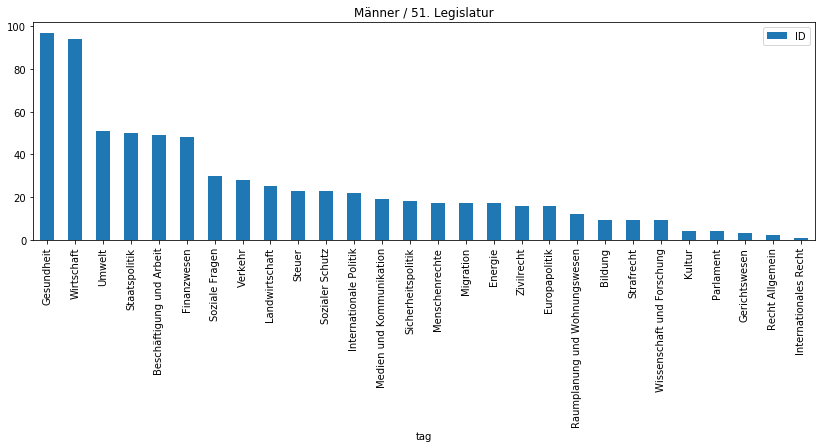

In [34]:
# Themenverteilung bei Männern in der 51. Legislatur
tag_gender[(tag_gender.GenderAsString == "m") & (tag_gender.SubmissionLegislativePeriod == 51)][['tag', 'ID']].sort_values(by="ID", ascending=False).plot.bar(x='tag', y='ID', title="Männer / 51. Legislatur", figsize=(14,4))

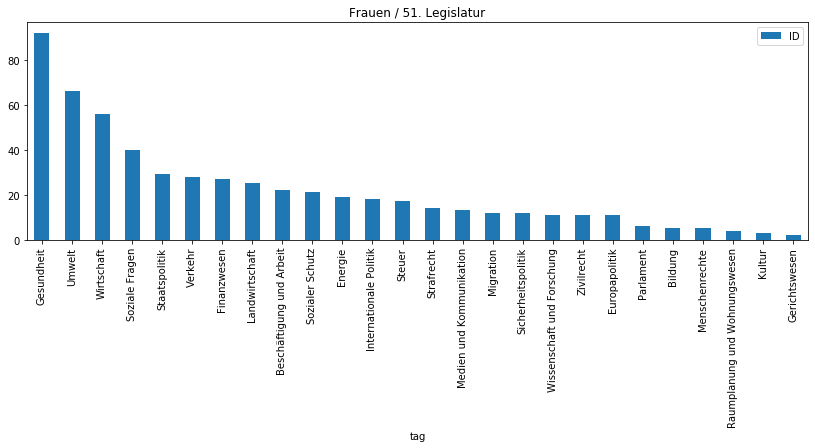

In [35]:
# Themenverteilung bei Frauen in der 51. Legislatur
tag_gender[(tag_gender.GenderAsString == "f") & (tag_gender.SubmissionLegislativePeriod == 51)][['tag', 'ID']].sort_values(by="ID", ascending=False).plot.bar(x='tag', y='ID', title="Frauen / 51. Legislatur", figsize=(14,4))

#### Differenz Männer / Frauen

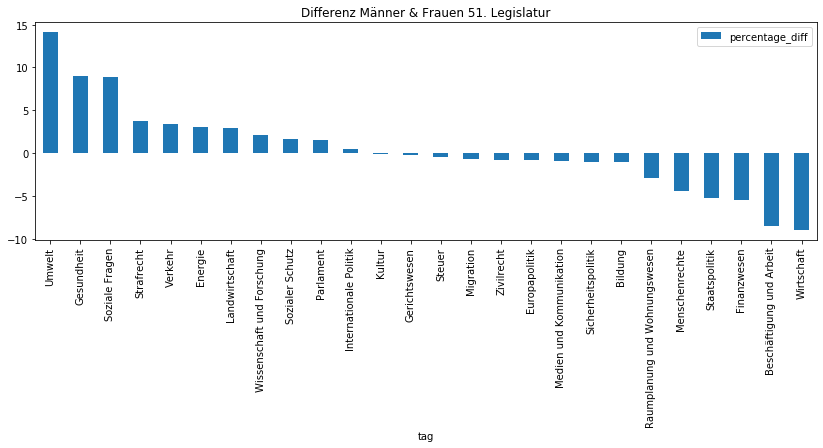

In [36]:
# Unterschiede zwischen Männern und Frauen in der 51. Legislatur
diff_51 = tag_gender[(tag_gender.GenderAsString == "f") & (tag_gender.SubmissionLegislativePeriod == 51)][['tag', 'ID']].merge(tag_gender[(tag_gender.GenderAsString == "m") & (tag_gender.SubmissionLegislativePeriod == 51)][['tag', 'ID']], on='tag', how='outer')
diff_51['percentage_f'] = 100 / len(full_data[(full_data.SubmissionLegislativePeriod == 51) & (full_data.GenderAsString == 'f')]) * diff_51.ID_x
diff_51['percentage_m'] = 100 / len(full_data[(full_data.SubmissionLegislativePeriod == 51) & (full_data.GenderAsString == 'm')]) * diff_51.ID_y
diff_51['percentage_diff'] = diff_51.percentage_f - diff_51.percentage_m
diff_51[~pd.isnull(diff_51.percentage_diff)].sort_values(by="percentage_diff", ascending=False).plot.bar(x='tag', y='percentage_diff', title="Differenz Männer & Frauen 51. Legislatur", figsize=(14,4))

In [58]:
# Tabelle der Unterschiede zwischen Männern und Frauen in der 51. Legislatur
diff_51[~pd.isnull(diff_51.percentage_diff)].sort_values(by="percentage_diff", ascending=False)

,tag,ID_x,ID_y,percentage_f,percentage_m,percentage_diff
21,Umwelt,66.0,51,35.106383,20.987654,14.118729
6,Gesundheit,92.0,97,48.936170,39.917695,9.018475
16,Soziale Fragen,40.0,30,21.276596,12.345679,8.930917
20,Strafrecht,14.0,9,7.446809,3.703704,3.743105
22,Verkehr,28.0,28,14.893617,11.522634,3.370983
2,Energie,19.0,17,10.106383,6.995885,3.110498
9,Landwirtschaft,25.0,25,13.297872,10.288066,3.009806
24,Wissenschaft und Forschung,11.0,9,5.851064,3.703704,2.147360
17,Sozialer Schutz,21.0,23,11.170213,9.465021,1.705192
13,Parlament,6.0,4,3.191489,1.646091,1.545399


#### 50. Legislatur

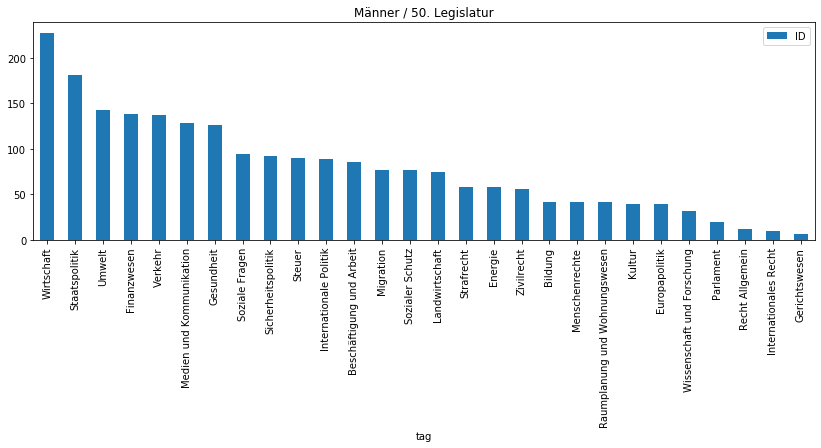

In [30]:
# Themenverteilung bei Männern in der 50. Legislatur
tag_gender[(tag_gender.GenderAsString == "m") & (tag_gender.SubmissionLegislativePeriod == 50)][['tag', 'ID']].sort_values(by="ID", ascending=False).plot.bar(x='tag', y='ID', title="Männer / 50. Legislatur", figsize=(14,4))

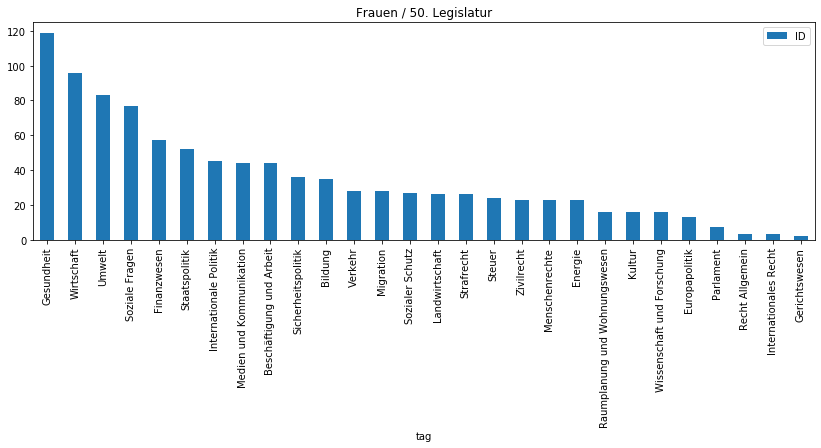

In [38]:
# Themenverteilung bei Frauen in der 50. Legislatur
tag_gender[(tag_gender.GenderAsString == "f") & (tag_gender.SubmissionLegislativePeriod == 50)][['tag', 'ID']].sort_values(by="ID", ascending=False).plot.bar(x='tag', y='ID', title="Frauen / 50. Legislatur", figsize=(14,4))

#### Differenz Männer & Frauen

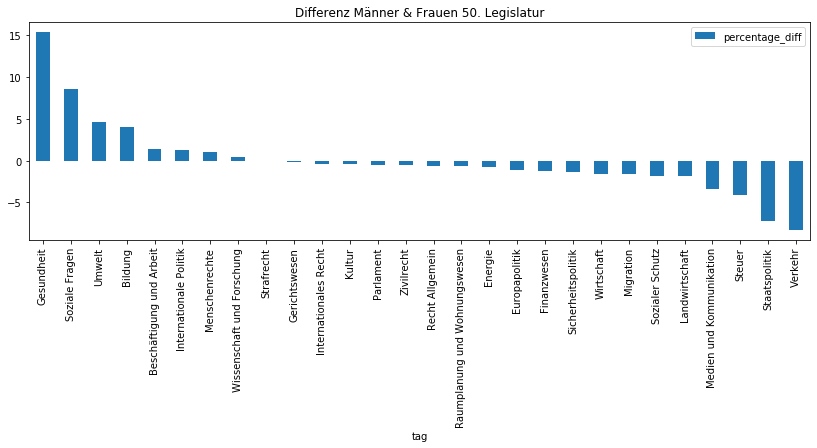

In [39]:
# Unterschiede zwischen Männern und Frauen in der 50. Legislatur
diff_50 = tag_gender[(tag_gender.GenderAsString == "f") & (tag_gender.SubmissionLegislativePeriod == 50)][['tag', 'ID']].merge(tag_gender[(tag_gender.GenderAsString == "m") & (tag_gender.SubmissionLegislativePeriod == 50)][['tag', 'ID']], on='tag', how='outer')
diff_50['percentage_f'] = 100 / len(full_data[(full_data.SubmissionLegislativePeriod == 50) & (full_data.GenderAsString == 'f')]) * diff_50.ID_x
diff_50['percentage_m'] = 100 / len(full_data[(full_data.SubmissionLegislativePeriod == 50) & (full_data.GenderAsString == 'm')]) * diff_50.ID_y
diff_50['percentage_diff'] = diff_50.percentage_f - diff_50.percentage_m
diff_50[~pd.isnull(diff_50.percentage_diff)].sort_values(by="percentage_diff", ascending=False).plot.bar(x='tag', y='percentage_diff', title="Differenz Männer & Frauen 50. Legislatur", figsize=(14,4))

In [40]:
# Tabelle zu Unterschieden zwischen Männern und Frauen in der 51. Legislatur
diff_50[~pd.isnull(diff_50.percentage_diff)].sort_values(by="percentage_diff", ascending=False)

,tag,ID_x,ID_y,percentage_f,percentage_m,percentage_diff
6,Gesundheit,119,126,29.382716,13.984462,15.398254
18,Soziale Fragen,77,94,19.012346,10.432852,8.579493
23,Umwelt,83,143,20.493827,15.871254,4.622573
1,Bildung,35,42,8.641975,4.661487,3.980488
0,Beschäftigung und Arbeit,44,85,10.864198,9.433962,1.430235
7,Internationale Politik,45,89,11.111111,9.877913,1.233198
12,Menschenrechte,23,42,5.679012,4.661487,1.017525
26,Wissenschaft und Forschung,16,32,3.950617,3.551609,0.399008
22,Strafrecht,26,58,6.419753,6.437292,-0.017539
5,Gerichtswesen,2,6,0.493827,0.665927,-0.172100


## Neue Parlamentarierinnen vs. "alte" in der 51. Legislatur

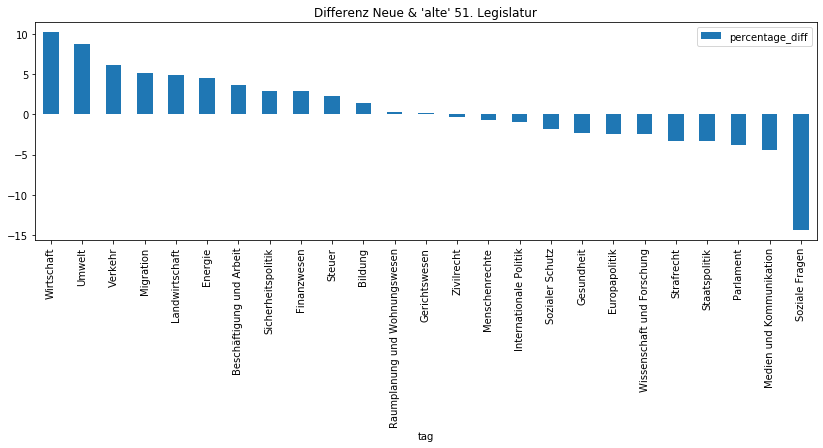

In [58]:
# Unterschiede zwischen Neuegwählten und bestehenden ParlamentarienInnen in der 51. Legislatur
diff_new = tag_newmembers[tag_newmembers.NewMember == True][['tag', 'ID']].merge(tag_newmembers[tag_newmembers.NewMember == False][['tag', 'ID']], on='tag', how='outer')
diff_new['percentage_new'] = 100 / len(full_data[(full_data.SubmissionLegislativePeriod == 51) & (full_data.GenderAsString == 'f') & (full_data.NewMember == True)]) * diff_new.ID_x
diff_new['percentage_old'] = 100 / len(full_data[(full_data.SubmissionLegislativePeriod == 51) & (full_data.GenderAsString == 'f') & (full_data.NewMember == False)]) * diff_new.ID_y
diff_new['percentage_diff'] = diff_new.percentage_new - diff_new.percentage_old
diff_new[~pd.isnull(diff_new.percentage_diff)].sort_values(by="percentage_diff", ascending=False).plot.bar(x='tag', y='percentage_diff', title="Differenz Neue & 'alte' 51. Legislatur", figsize=(14,4))

## Geschlechterunterschiede nach Fraktion

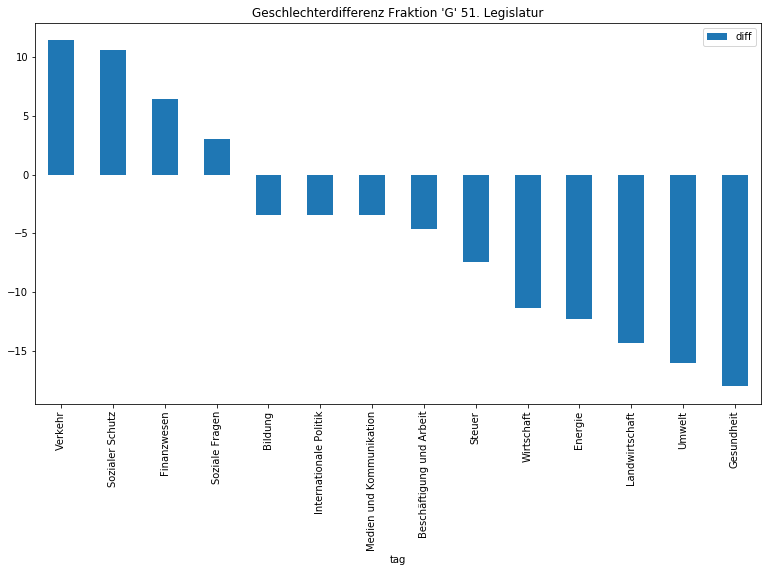

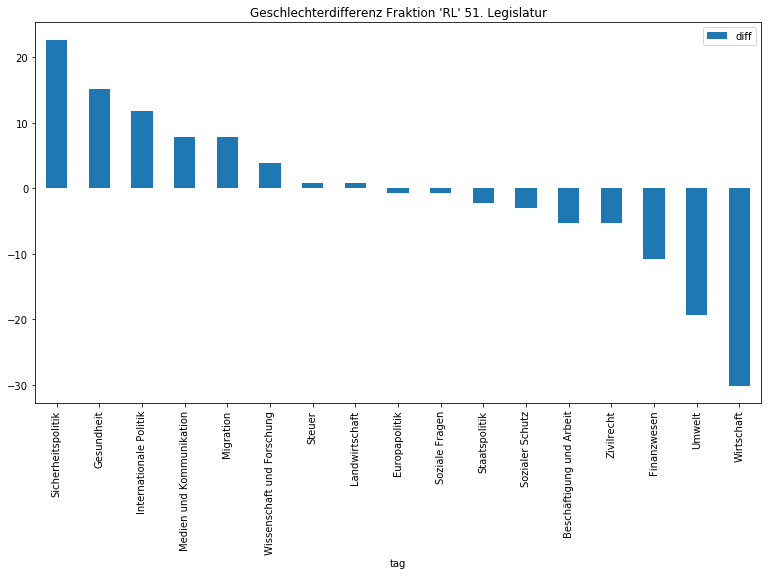

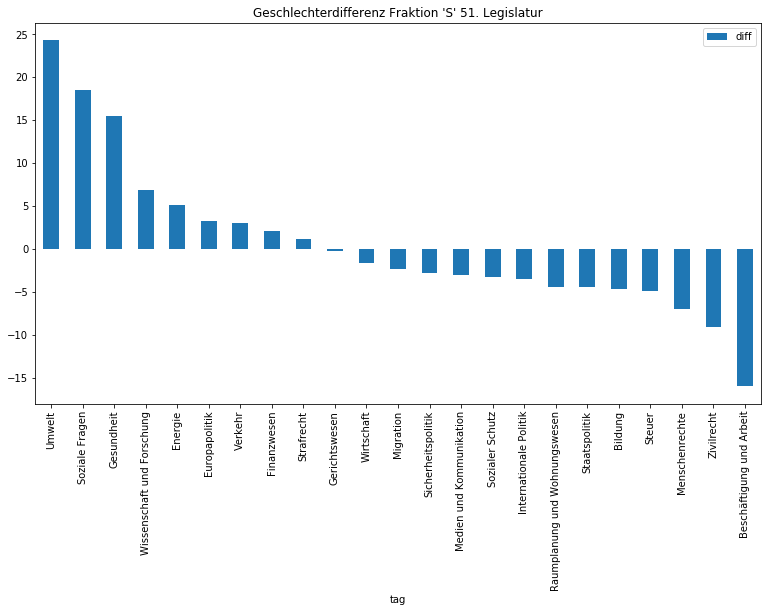

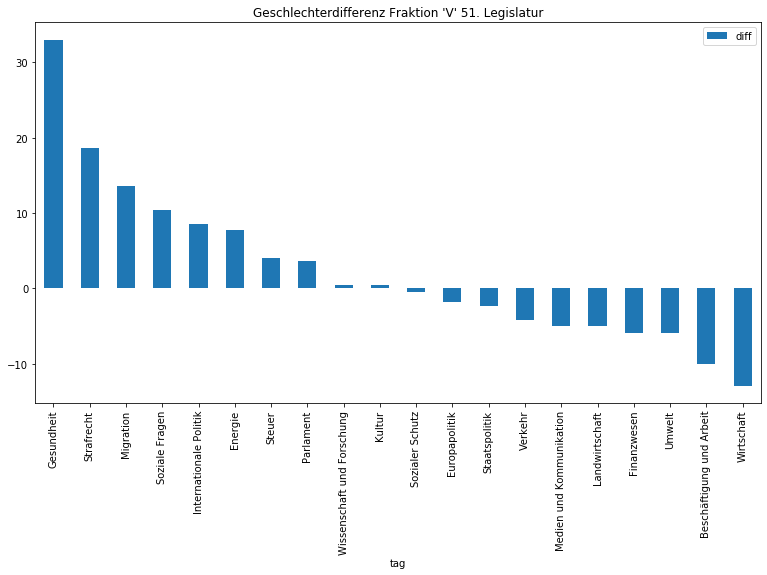

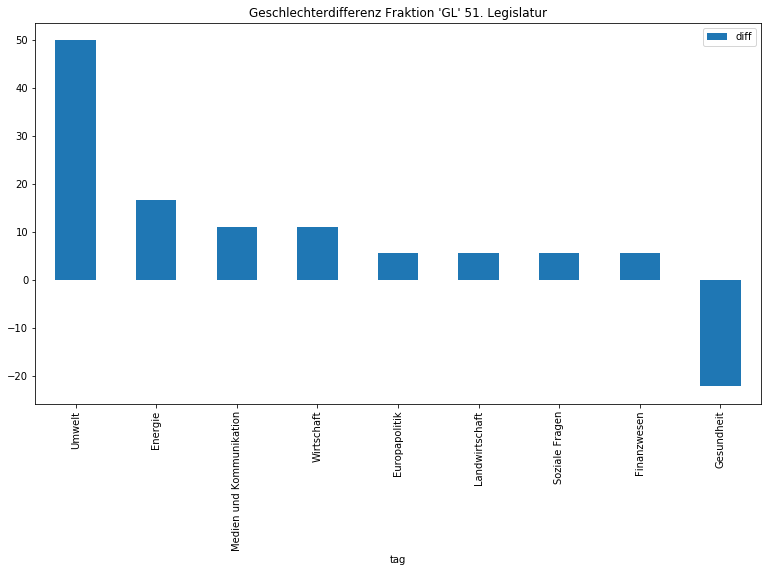

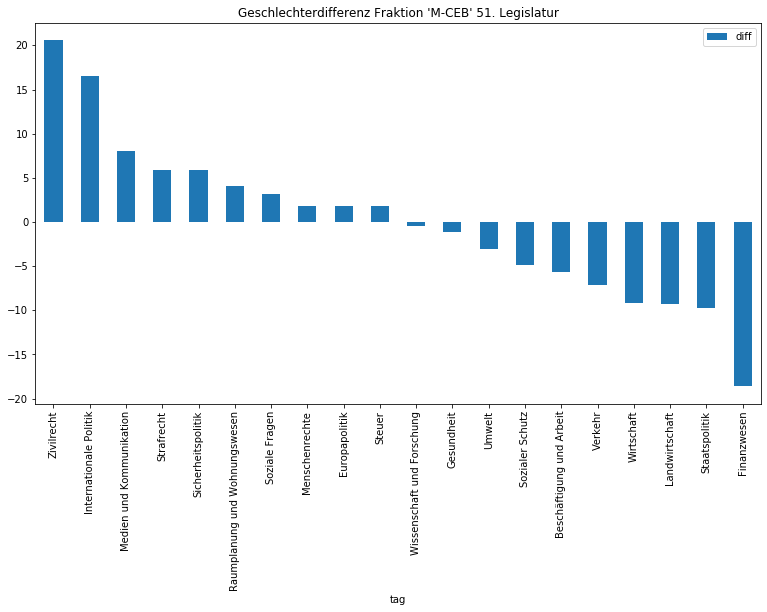

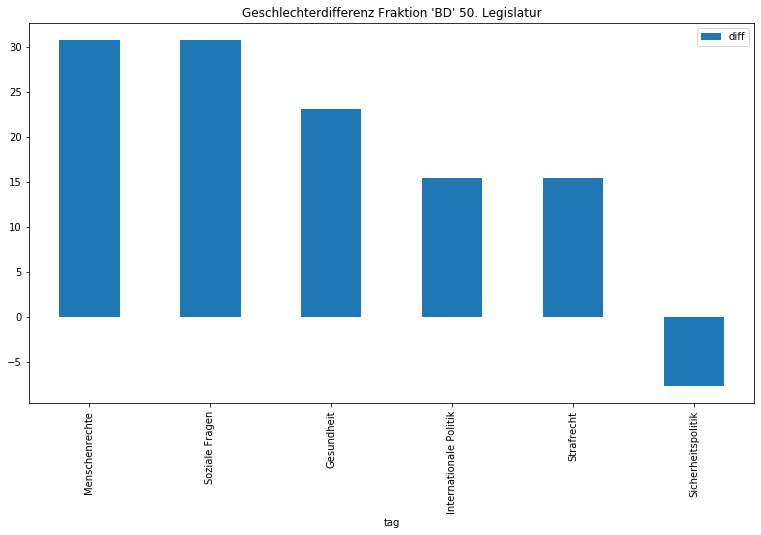

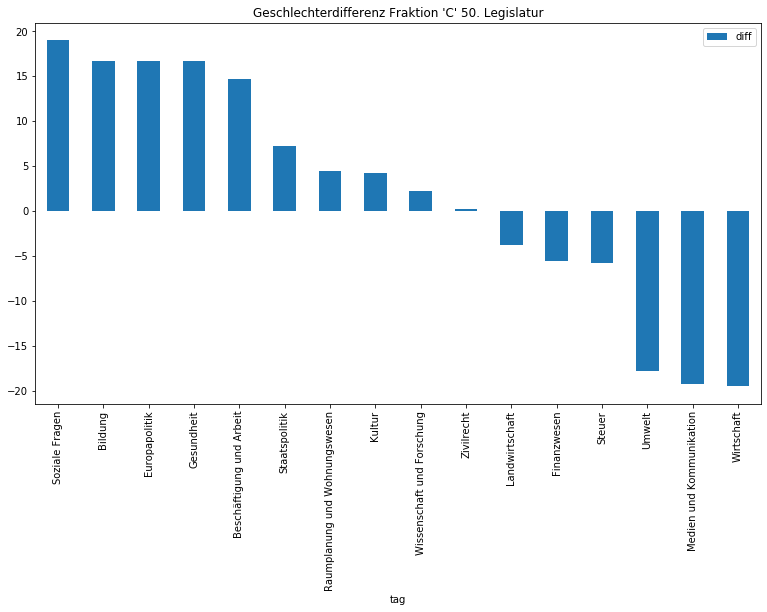

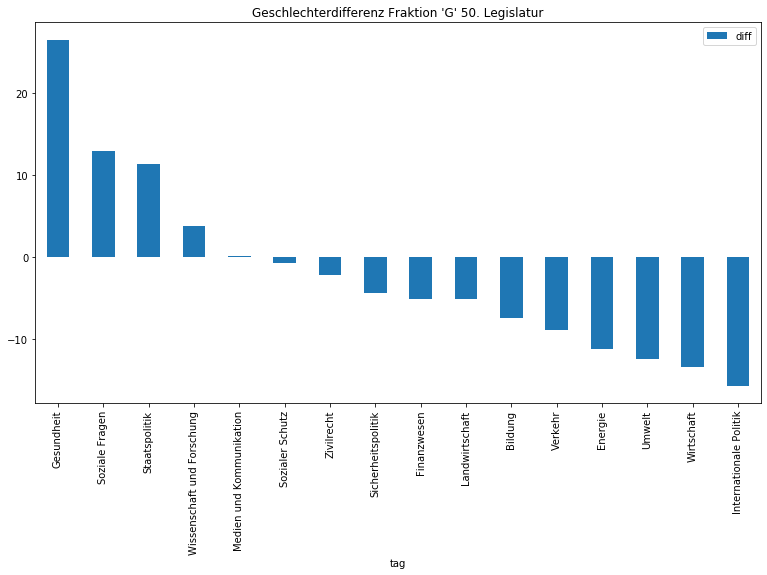

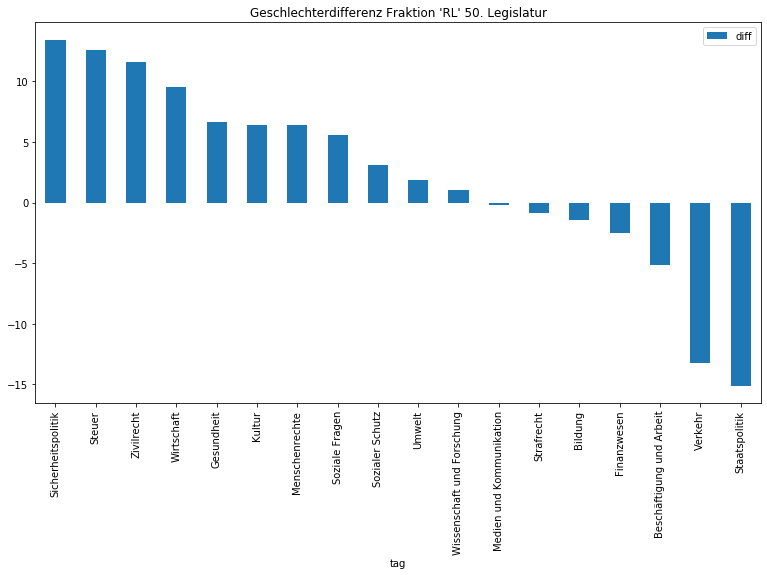

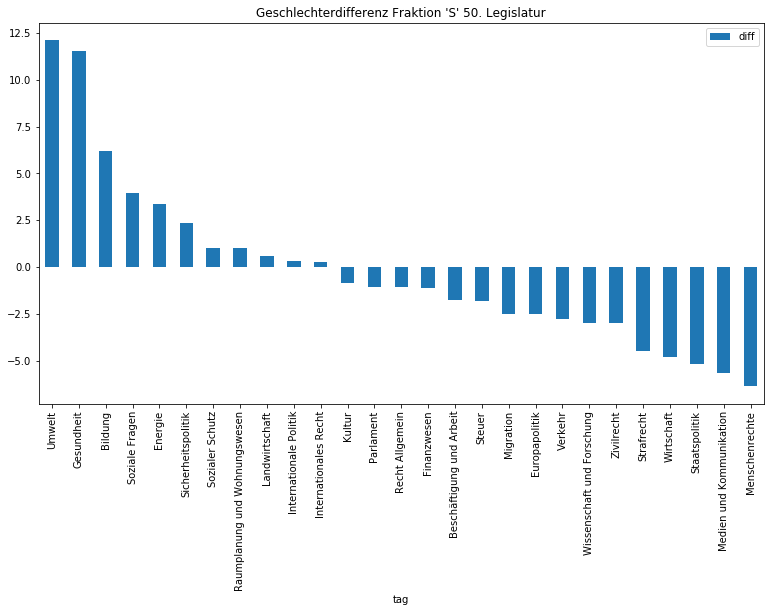

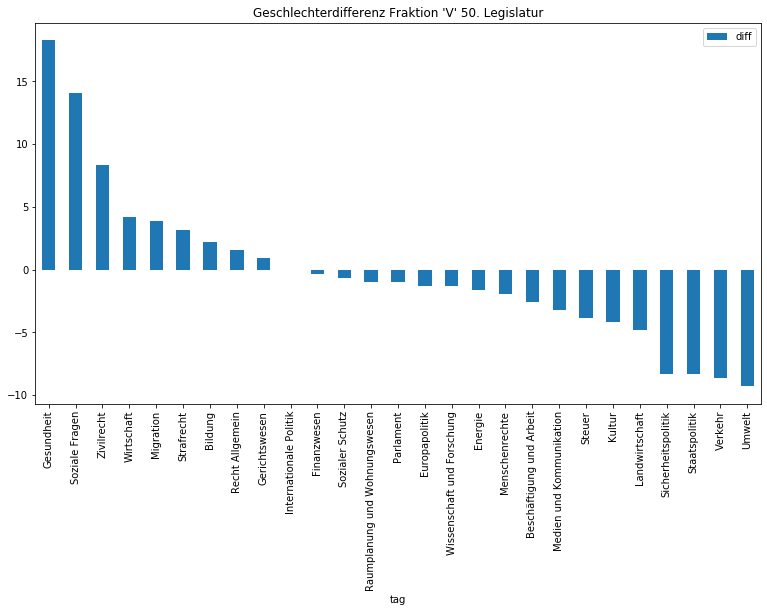

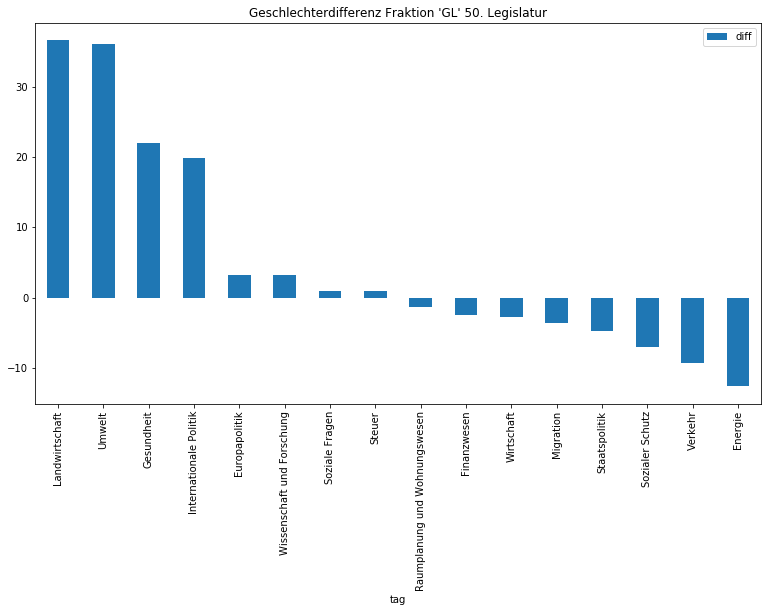

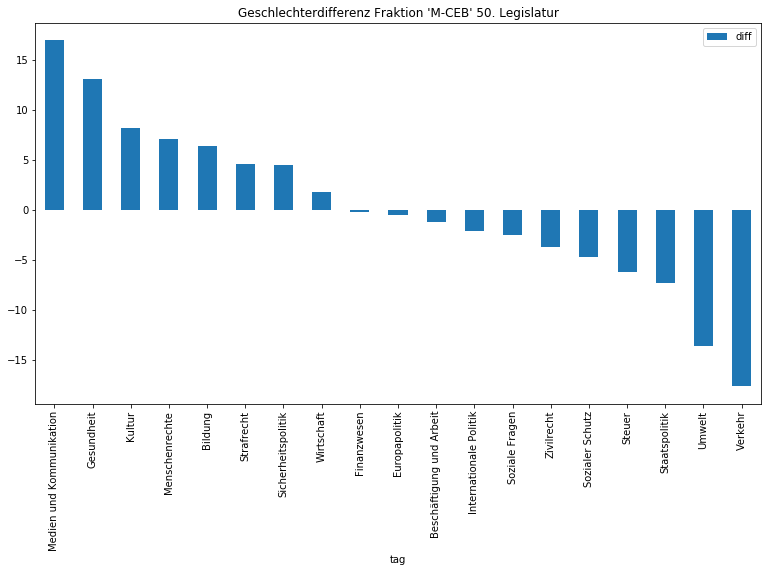

In [45]:
# Fraktionsinsterne Geschlechterunterschiede in der 50. und 51. Legislatur
i = 0
for period in [51, 50]:
    for parlgroup in tag_parlgroup_gender.ParlGroupAbbreviation.unique():
        len_f = len(full_data[(full_data.SubmissionLegislativePeriod == period) & 
                              (full_data.ParlGroupAbbreviation == parlgroup) & 
                              (full_data.GenderAsString == 'f')])
        len_m = len(full_data[(full_data.SubmissionLegislativePeriod == period) & 
                              (full_data.ParlGroupAbbreviation == parlgroup) & 
                              (full_data.GenderAsString == 'm')])
        temp = tag_parlgroup_gender[(tag_parlgroup_gender.ParlGroupAbbreviation == parlgroup) & 
                                    (tag_parlgroup_gender.SubmissionLegislativePeriod == period) & 
                                    (tag_parlgroup_gender.GenderAsString == 'f')][['tag', 'ID']].merge(
            tag_parlgroup_gender[(tag_parlgroup_gender.ParlGroupAbbreviation == parlgroup) & 
                                 (tag_parlgroup_gender.SubmissionLegislativePeriod == period) & 
                                 (tag_parlgroup_gender.GenderAsString == 'm')][['tag', 'ID']], 
            on='tag',
            how='outer')
        
        if (len_f > 0) & (len_m > 0):
            temp['pct_f'] = 100 / len_f * temp.ID_x
            temp['pct_m'] = 100 / len_m * temp.ID_y
            temp['diff'] = temp['pct_f'] - temp['pct_m']
            label = temp[~pd.isnull(temp['diff'])].sort_values(by="diff", ascending=False).tag.tolist()
            values = temp[~pd.isnull(temp['diff'])].sort_values(by="diff", ascending=False)['diff'].tolist()
            temp[~pd.isnull(temp['diff'])].sort_values(by="diff", ascending=False).plot.bar(x='tag', y='diff', title=f"Geschlechterdifferenz Fraktion '{parlgroup}' {period}. Legislatur", figsize=(13,7))
            i+=1

## Kennzahlen

In [35]:
# Anzahl Vorstösse von neu gewählten Frauen
len(full_data[(full_data.NewMember == True) & (full_data.GenderAsString == 'f')])

88

In [36]:
# Anzahl Vorstösse von Frauen insgesamt in der 51. Legislatur
len(full_data[(full_data.SubmissionLegislativePeriod == 51) & (full_data.GenderAsString == 'f')])

188

In [37]:
# Parlamentarierinnen mit den meisten Vorstösen
(full_data[(full_data.NewMember == True) & (full_data.GenderAsString == 'f')]['FirstName'] + full_data[(full_data.NewMember == True) & (full_data.GenderAsString == 'f')]['LastName']).value_counts()

LéonorePorchet                   8
MeretSchneider                   7
MartinaBircher                   7
DelphineKlopfenstein Broggini    6
ValentinePython                  6
SophieMichaud Gigon              6
Jacquelinede Quattro             5
TamaraFuniciello                 4
ChristineBadertscher             4
GretaGysin                       4
StefaniaPrezioso Batou           4
BarbaraSchaffner                 3
IsabellePasquier-Eichenberger    3
MarionnaSchlatter                3
FranziskaRoth                    3
FlorenceBrenzikofer              3
KatjaChrist                      2
Simonede Montmollin              2
FranziskaRyser                   2
StefanieHeimgartner              1
CélineWidmer                     1
EstherFriedli                    1
MajaRiniker                      1
SandraLocher Benguerel           1
SusanneVincenz-Stauffacher       1
dtype: int64

In [38]:
# Dominierende Themen bei Neugewählten
tag_list[(tag_list.NewMember == True) & (tag_list.GenderAsString == 'f')]['tag'].value_counts()

Gesundheit                       42
Umwelt                           35
Wirtschaft                       31
Verkehr                          16
Finanzwesen                      14
Landwirtschaft                   14
Staatspolitik                    12
Soziale Fragen                   12
Beschäftigung und Arbeit         12
Energie                          11
Sozialer Schutz                   9
Steuer                            9
Internationale Politik            8
Migration                         8
Sicherheitspolitik                7
Zivilrecht                        5
Strafrecht                        5
Wissenschaft und Forschung        4
Europapolitik                     4
Medien und Kommunikation          4
Bildung                           3
Menschenrechte                    2
Raumplanung und Wohnungswesen     2
Gerichtswesen                     1
Parlament                         1
Name: tag, dtype: int64

In [40]:
# Allgemeine Rangliste der Personen mit den meisten Vorstössen in der 51. Legislatur:
pd.DataFrame(full_data[full_data.SubmissionLegislativePeriod == 51][['ID_x', 'SubmittedBy']].drop_duplicates().SubmittedBy.value_counts()).head(20)

,SubmittedBy
Addor Jean-Luc,12
Feller Olivier,9
Quadri Lorenzo,9
Porchet Léonore,8
Reimann Lukas,8
Regazzi Fabio,8
Reynard Mathias,8
Bircher Martina,7
Romano Marco,7
Schneider Meret,7


In [41]:
# Allgemeine Rangliste der Personen mit den meisten Vorstössen in der 50. Legislatur:
pd.DataFrame(full_data[full_data.SubmissionLegislativePeriod == 50][['ID_x', 'SubmittedBy']].drop_duplicates().SubmittedBy.value_counts()).head(20)

,SubmittedBy
Addor Jean-Luc,29
Reimann Lukas,26
Nantermod Philippe,24
Reynard Mathias,22
Munz Martina,22
Romano Marco,21
Quadri Lorenzo,20
Béglé Claude,19
Feller Olivier,19
Estermann Yvette,18


In [56]:
### durchschnittliche Motionen pro Kopf pro Legislatur ermitteln
motionen_pp = full_data[['ID_x', 'GenderAsString', 'SubmissionLegislativePeriod']].groupby(['SubmissionLegislativePeriod', 'GenderAsString']).count().reset_index()
motionen_pp = motionen_pp.merge(pd.DataFrame({'Anzahl_Personen': [47, 153, 52, 148, 59, 141, 58, 142, 64, 136, 84, 116]}), left_index=True, right_index=True, how="left")
motionen_pp['motion_pp'] = motionen_pp.ID_x / motionen_pp.Anzahl_Personen
sessionen_p_legislatur = pd.DataFrame({'Legislatur': [46, 47, 48, 49, 50, 51],
                                       'Sessionen': [20, 18, 20, 20, 19, 7]})
motionen_pp = motionen_pp.merge(sessionen_p_legislatur, left_on='SubmissionLegislativePeriod', right_on='Legislatur', how='left')
motionen_pp['motionen_ps'] = motionen_pp.motion_pp / motionen_pp.Sessionen

---

## Export der Daten



In [57]:
diff_51[~pd.isnull(diff_51.percentage_diff)].sort_values(by="percentage_diff", ascending=False).to_excel('output/vis_spider.xlsx', index=False)

In [33]:
diff_50[~pd.isnull(diff_50.percentage_diff)].sort_values(by="percentage_diff", ascending=False).to_excel('output/vis_spider50.xlsx', index=False)

In [ ]:
parlgroup_f_m.rename(columns={"ID": "Count"}).to_excel('output/fraktionen_m_f_vis.xlsx')

In [31]:
motionen_pp[['Legislatur', 'GenderAsString', 'motion_pp']].pivot(index='Legislatur', columns='GenderAsString', values='motion_pp').to_csv('output/motionen_pp.csv')

## Check für Radar-Chart:
Kommt man auf ähnlich Resulate, wenn Geschlechterunterschiede gewichtet nach Fraktionsstärke berechnet werden?

In [53]:
period = 51

parlgroup_f = pd.DataFrame(index = tag_parlgroup_gender[(tag_parlgroup_gender.SubmissionLegislativePeriod == period) & 
                            (tag_parlgroup_gender.GenderAsString == 'f')][['tag']].drop_duplicates().tag.tolist())
parlgroup_m = pd.DataFrame(index = tag_parlgroup_gender[(tag_parlgroup_gender.SubmissionLegislativePeriod == period) & 
                            (tag_parlgroup_gender.GenderAsString == 'm')][['tag']].drop_duplicates().tag.tolist())

for parlgroup in tag_parlgroup_gender[tag_parlgroup_gender.SubmissionLegislativePeriod == period].ParlGroupAbbreviation.unique():
    temp = tag_parlgroup_gender[(tag_parlgroup_gender.ParlGroupAbbreviation == parlgroup) & 
                            (tag_parlgroup_gender.SubmissionLegislativePeriod == period) & 
                            (tag_parlgroup_gender.GenderAsString == 'f')][['tag', 'ID']]
    temp = temp.set_index('tag')
    temp.columns = [parlgroup]
    temp[parlgroup] = 100 / len(full_data[(full_data.ParlGroupAbbreviation == parlgroup) & 
              (full_data.SubmissionLegislativePeriod == period) & 
              (full_data.GenderAsString == 'f')]) * temp[parlgroup]
    parlgroup_f = parlgroup_f.merge(temp, left_index=True, right_index=True, how='left')
    
    
    
    temp = tag_parlgroup_gender[(tag_parlgroup_gender.ParlGroupAbbreviation == parlgroup) & 
                            (tag_parlgroup_gender.SubmissionLegislativePeriod == period) & 
                            (tag_parlgroup_gender.GenderAsString == 'm')][['tag', 'ID']]
    temp = temp.set_index('tag')
    temp.columns = [parlgroup]
    temp[parlgroup] = 100 / len(full_data[(full_data.ParlGroupAbbreviation == parlgroup) & 
              (full_data.SubmissionLegislativePeriod == period) & 
              (full_data.GenderAsString == 'm')]) * temp[parlgroup]
    parlgroup_m = parlgroup_m.merge(temp, left_index=True, right_index=True, how='left')
    
parlgroup_f = parlgroup_f.fillna(0)
parlgroup_m = parlgroup_m.fillna(0)

for i, row in parlgroup_f.iterrows():
    g = (row['G'] / 200 * 30)
    gl = (row['GL'] / 200 * 16)
    mceb = (row['M-CEB'] / 200 * 31)
    rl = (row['RL'] / 200 * 29)
    s = (row['S'] / 200 * 39)
    v = (row['V'] / 200 * 55)
    mean = g + gl + mceb + rl + s + v
    parlgroup_f.loc[i, "Mittelwert_f"] = mean
    
    
for i, row in parlgroup_m.iterrows():
    g = (row['G'] / 200 * 30)
    gl = (row['GL'] / 200 * 16)
    mceb = (row['M-CEB'] / 200 * 31)
    rl = (row['RL'] / 200 * 29)
    s = (row['S'] / 200 * 39)
    v = (row['V'] / 200 * 55)
    mean = g + gl + mceb + rl + s + v
    parlgroup_m.loc[i, "Mittelwert_m"] = mean

parlgroup_f_m = parlgroup_f[['Mittelwert_f']].merge(parlgroup_m[['Mittelwert_m']], left_index=True, right_index=True, how='outer').fillna(0)

parlgroup_f_m = parlgroup_f_m.merge(tag_list[tag_list.SubmissionLegislativePeriod == period][['tag', 'ID']].groupby('tag').count(), left_index=True, right_index=True, how='outer').fillna(0)

In [54]:
parlgroup_f_m

,Mittelwert_f,Mittelwert_m,ID
Beschäftigung und Arbeit,10.591843,20.175991,71
Bildung,2.051007,3.972546,14
Energie,8.873631,8.640246,36
Europapolitik,7.130869,5.971160,27
Finanzwesen,14.068075,18.341623,75
Gerichtswesen,1.267361,1.159675,5
Gesundheit,51.800078,42.165436,189
Internationale Politik,13.214202,9.107642,40
Internationales Recht,0.000000,0.406250,1
Kultur,1.822379,1.574581,7
